# Diagnosis of Cardiac Arrhythmia with PCA And MLP

## Dataset was downloaded  from here : https://archive.ics.uci.edu/ml/datasets/arrhythmia

In [32]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from IPython.display import clear_output    


from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [9]:
# set some parameter for show figure in beter style
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot') # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'
%matplotlib inline

## Read datase

In [10]:
df = pd.read_csv('./arrhythmia.data',header=None)
print(f'dataset shape is equal : {df.shape}')
df.head(2)

dataset shape is equal : (452, 280)


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6


# Dataset Preparation

In [11]:
# shuffle 
df = df.sample(frac=1, random_state=0).reset_index(drop=True)   
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,37,1,159,56,75,162,339,141,96,60,...,0.0,5.0,-1.3,0.0,0.0,0.4,1.2,9.4,16.6,1
1,52,0,165,80,88,202,369,113,97,58,...,-0.5,10.7,-1.7,0.0,0.0,0.4,-0.3,19.6,17.7,16


In [12]:
# replace ? with mean value
for c in df.iloc[:,:-1].columns:        
    notMissedIndex = df[c].apply(lambda x : str(x) != '?')    
    MissedIndex = df[c].apply(lambda x : str(x) == '?')    
    mean = np.mean(df[c][notMissedIndex].apply(lambda x : float(x)).unique())          
    df[c] = df[c].replace('?', mean)    
    df[c] = df[c].apply(lambda x : float(x))    

In [13]:
for i in [0,5,8]: # replace 0 with mean value
    notMissedIndex = df.iloc[:,i].apply(lambda x : x != 0)
    MissedIndex = df.iloc[:,i].apply(lambda x : x == 0)
    mean = np.mean(df.iloc[:,i][notMissedIndex].apply(lambda x : x).unique())          
    df.iloc[:,i] = df.iloc[:,i].replace(0, mean)    

In [14]:
for c in df.iloc[:,:-1].columns: # standardization
    if(sum(df[c].unique()) > 2):
        df[c] = (df[c] - df[c].mean()) / df[c].std()    
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,-0.6,1.0,-0.2,-0.7,-0.9,0.0,-0.8,-0.8,0.2,0.6,...,0.0,-1.2,-1.3,0.0,0.0,-0.3,-0.0,-0.7,-0.7,1
1,0.3,0.0,-0.0,0.7,-0.1,1.3,0.1,-1.6,0.2,0.5,...,-0.5,0.5,-1.7,0.0,0.0,-0.3,-1.1,0.0,-0.6,16


## In First step, split Feature and Tag from each other

In [15]:
X = df.iloc[:,:-1]
print(f'Feature shape : {X.shape}')
X.head(2)

Feature shape : (452, 279)


,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,-0.6,1.0,-0.2,-0.7,-0.9,0.0,-0.8,-0.8,0.2,0.6,...,0.0,0.0,-1.2,-1.3,0.0,0.0,-0.3,-0.0,-0.7,-0.7
1,0.3,0.0,-0.0,0.7,-0.1,1.3,0.1,-1.6,0.2,0.5,...,-0.4,-0.5,0.5,-1.7,0.0,0.0,-0.3,-1.1,0.0,-0.6


In [16]:
Y = df.iloc[:,-1]
print(f'Target shape : {Y.shape}')
Y.head(2)

Target shape : (452,)


0     1
1    16
Name: 279, dtype: int64

## Use PCA in Dataset

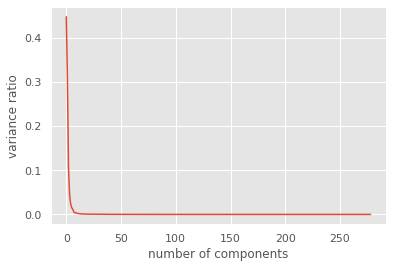

In [17]:
pca = PCA(n_components=279)
principal = pca.fit_transform(X)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('variance ratio')
plt.show()

lowest number of components with variances cutoff 0.995 is 43


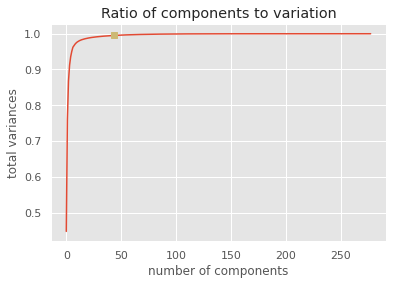

In [18]:
variance_cutoff = 0.995 # save 99.5 % of data ratio

variances = list()
for i in range(1,X.shape[1]):
    pca = PCA(n_components=i)
    principal = pca.fit_transform(X)
    variances.append(sum(pca.explained_variance_ratio_))
d = [i for i in range(0,len(variances)) if variances[i] >= variance_cutoff][0]
print(f'lowest number of components with variances cutoff {variance_cutoff} is {d}')

plt.plot(variances)
plt.plot(d,variances[d],'ys')
plt.xlabel('number of components')
plt.ylabel('total variances')
plt.title('Ratio of components to variation')
plt.show()

In [19]:
pca = PCA(n_components=d)
Xpca = pca.fit_transform(X)

# Train Test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, Y, test_size = 0.3, random_state = 0)
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (316, 43)
y_train shape : (316,)
X_test shape : (136, 43)
y_test shape : (136,)


# Run for two class mode :

In [21]:
y_train2 = y_train.apply(lambda x : int(x != 1))
y_test2 = y_test.apply(lambda x : int(x != 1))

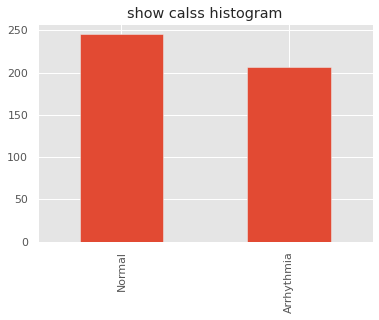

In [22]:
tag = df.iloc[:,-1]
tag = tag != 1
ax = tag.value_counts(sort = False).plot(kind='bar',title='show calss histogram')
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Normal', 'Arrhythmia'])
plt.show()

# Use sklearn MLP

In [23]:
alpha = 0.01
clf = MLPClassifier(max_iter=10000, activation='relu', solver='adam', alpha=alpha,learning_rate = 'invscaling'
                    ,learning_rate_init = 0.01, power_t = 0.2,
                     hidden_layer_sizes=(43,43,21,10,5),momentum=0.9,batch_size='auto', random_state=10, validation_fraction=0.15
                   ,early_stopping =True, n_iter_no_change= 50)

scores = cross_val_score(clf, X_train, y_train2, cv=5)
print(scores)
print(scores.mean())

[0.6875     0.52380952 0.76190476 0.65079365 0.77777778]
0.6803571428571428


In [24]:
clf.fit(X_train,y_train2)

MLPClassifier(alpha=0.01, early_stopping=True,
              hidden_layer_sizes=(43, 43, 21, 10, 5),
              learning_rate='invscaling', learning_rate_init=0.01,
              max_iter=10000, n_iter_no_change=50, power_t=0.2, random_state=10,
              validation_fraction=0.15)

In [25]:
print(f'Train accuracy is : {metrics.accuracy_score(clf.predict(X_train), y_train2)}')
print(f'Test accuracy is : {metrics.accuracy_score(clf.predict(X_test), y_test2)}')

Train accuracy is : 0.9145569620253164
Test accuracy is : 0.6764705882352942


# Train data confusion matrix

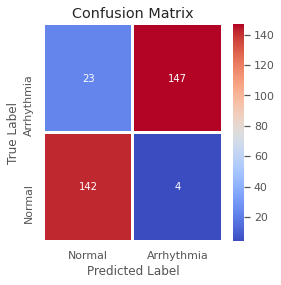

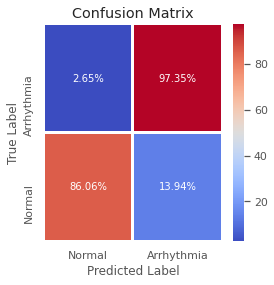

In [59]:
matrix = metrics.confusion_matrix(y_train2, clf.predict(X_train))
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=['Normal', 'Arrhythmia'],yticklabels=['Normal', 'Arrhythmia'],annot=True,fmt="d")    
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,2])
plt.show()    

matrix = metrics.confusion_matrix(y_train2, clf.predict(X_train))
matrix =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=['Normal', 'Arrhythmia'],yticklabels=['Normal', 'Arrhythmia'],annot=True,fmt=".2f")    
for t in ax.texts:t.set_text(t.get_text() + "%")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,2])
plt.show()    

# Test data confusion matrix

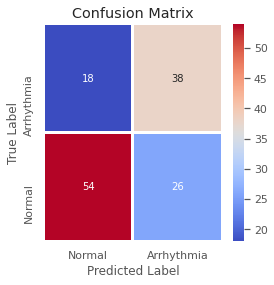

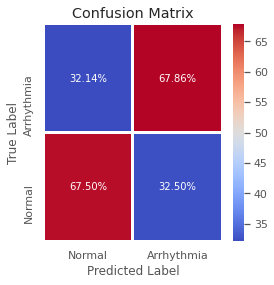

In [60]:
matrix = metrics.confusion_matrix(y_test2, clf.predict(X_test))
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=['Normal', 'Arrhythmia'],yticklabels=['Normal', 'Arrhythmia'],annot=True,fmt="d")    
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,2])
plt.show()    

matrix = metrics.confusion_matrix(y_test2, clf.predict(X_test))
matrix =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=['Normal', 'Arrhythmia'],yticklabels=['Normal', 'Arrhythmia'],annot=True,fmt=".2f")    
for t in ax.texts:t.set_text(t.get_text() + "%")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,2])
plt.show()    

# All data confusion matrix

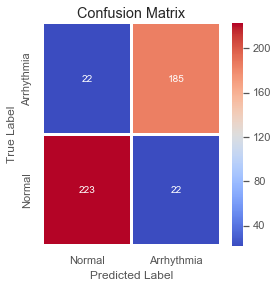

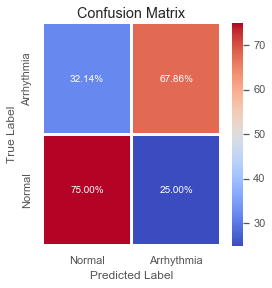

In [168]:
matrix = metrics.confusion_matrix(np.concatenate((y_train2, y_test2)), clf.predict(np.concatenate((X_train,X_test))))
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=['Normal', 'Arrhythmia'],yticklabels=['Normal', 'Arrhythmia'],annot=True,fmt="d")    
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,2])
plt.show()    

matrix = metrics.confusion_matrix(y_test2, clf.predict(X_test))
matrix =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=['Normal', 'Arrhythmia'],yticklabels=['Normal', 'Arrhythmia'],annot=True,fmt=".2f")    
for t in ax.texts:t.set_text(t.get_text() + "%")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,2])
plt.show()    

# for 16 class :

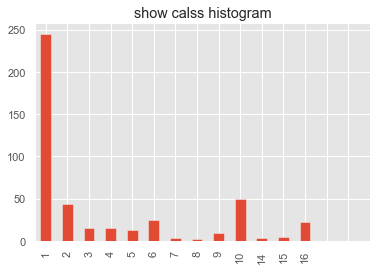

In [186]:
tag = df.iloc[:,-1]
ax = tag.value_counts(sort = False).plot(kind='bar',title='show calss histogram')
ax.set_xticks(range(0,16))
plt.show()

## Convert lable to one-hot

In [187]:
tag = np.zeros((y_train.shape[0],16),dtype=int)
for i in range(0,y_train.shape[0]):
    tag[i,y_train.iloc[i]-1] = 1
y_train = tag


tag = np.zeros((y_test.shape[0],16))
for i in range(0,y_test.shape[0]):
    tag[i,y_test.iloc[i] - 1] = 1
y_test = tag

### after cross validation chose hyperparameter value

In [198]:
alpha = 0.01
clf = MLPClassifier(max_iter=3000, activation='logistic', solver='adam', alpha=alpha,learning_rate = 'invscaling'
                    ,learning_rate_init = 0.01, power_t = 0.2,
                     hidden_layer_sizes=(43,43,21,16,),momentum=0.9,batch_size='auto', random_state=10, validation_fraction=0.15
                   ,early_stopping =True, n_iter_no_change= 50)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print(scores.mean())

[0.4375     0.61904762 0.46031746 0.6031746  0.49206349]
0.5224206349206348


In [199]:
clf.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(43, 43, 21, 16), learning_rate='invscaling',
              learning_rate_init=0.01, max_fun=15000, max_iter=3000,
              momentum=0.9, n_iter_no_change=50, nesterovs_momentum=True,
              power_t=0.2, random_state=10, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.15, verbose=False,
              warm_start=False)

In [ ]:
print(f'Train accuracy is : {metrics.accuracy_score(clf.predict(X_train), y_train)}')
print(f'Test accuracy is : {metrics.accuracy_score(clf.predict(X_test), y_test)}')

In [ ]:
matrix = create_confusion_matrix(np.argmax(np.concatenate((y_train,y_test)), axis=1), np.argmax(clf.predict(np.concatenate((X_train,X_test))),axis=1))
matrix =  np.nan_to_num(np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100 )
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(data=matrix, cmap="coolwarm",linecolor='white',linewidths=2,
    xticklabels=[str(i) for i in range(1,17)],yticklabels=[str(i) for i in range(1,17)],annot=True,fmt=".0f")    
for t in ax.texts:t.set_text(t.get_text() + "%")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ax.set_ylim([0,16])
plt.show()    